# Data for TSP Warehouse

In [424]:
import pandas as pd
import numpy as np
import os

In [425]:
df = pd.read_csv("static/fruits.csv")
df

,Name,Category
0,Abiu,Fruit
1,Açaí,Fruit
2,Acerola,Fruit
3,Akebi,Fruit
4,Ackee,Fruit
...,...,...
153,Pea,Fruit
154,Pumpkin,Fruit
155,Squash,Fruit
156,Tomato,Fruit


# Generate Graph

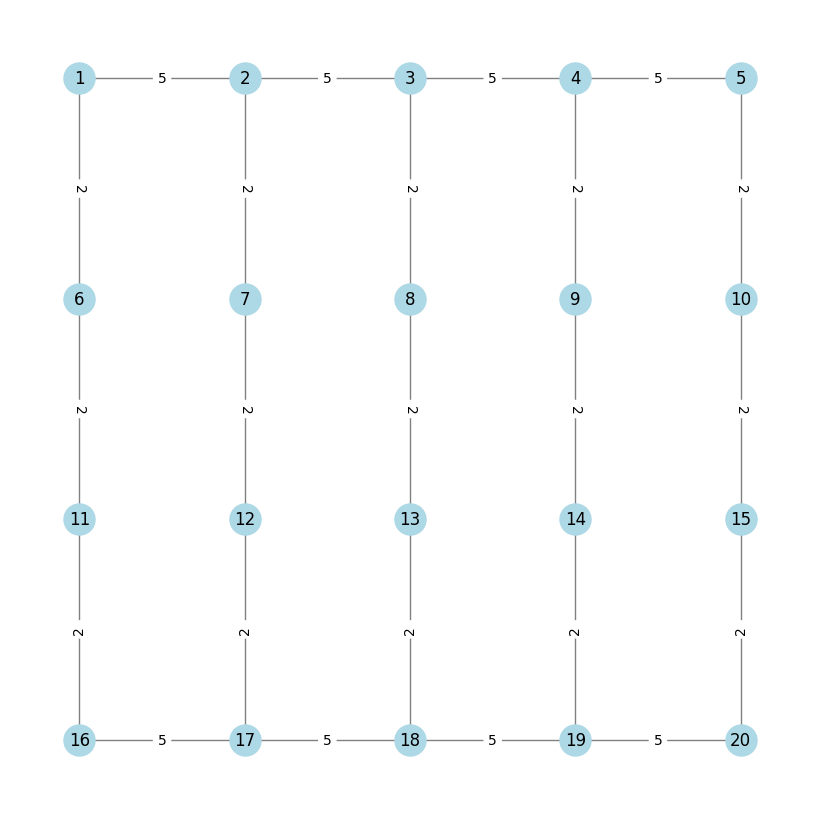

In [426]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.Graph()

# Define grid dimensions
n = 5  # Number of rows
m = 4  # Number of columns
n_bins = n * m

# Add edges within rows
for i in range(1, n):
    G.add_edge(i, i + 1, weight=5)

for i in range(n * m - n + 1, n * m):
    G.add_edge(i, i + 1, weight=5)

# Add edges between rows
for i in range(1, n * m - n + 1):
    G.add_edge(i, i + n, weight=2)

# Visualize the graph
pos = {}
for row in range(m):  # m is the number of rows
    for col in range(n):  # n is the number of columns
        node = row * n + col + 1
        pos[node] = (col, -row)  # Arrange nodes in a square grid

# Highlight the shortest path in the visualization
plt.figure(figsize=(8, 8))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    node_color="lightblue",
    edge_color="gray",
)

nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels={(u, v): f"{d['weight']}" for u, v, d in G.edges(data=True)},
    font_size=10,
    label_pos=0.5,
)
plt.axis("off")
plt.show()

# Assign fruit to bins

In [427]:
# new column with random integer
df["bin"] = np.random.randint(1, n_bins, df.shape[0])

In [428]:
# Generate work orders
wos = 100

# Check if wos file is already generated
if os.path.isfile(f"static/wos_{wos}.parquet"):
    df_wo = pd.read_parquet(f"static/wos_{wos}.parquet")
    print(f"Loaded {df_wo.shape[0]} work orders")
else:
    print(f"Generating {wos} work orders")
    df_wo = pd.DataFrame(columns=df.columns)
    for _ in range(wos):
        random_row = df.sample()
        df_wo = pd.concat([df_wo, random_row], ignore_index=True)
    df_wo.to_parquet(f"static/wos_{wos}.parquet")
df_wo.head()

Loaded 100 work orders


,Name,Category,bin
0,Loquat,Fruit,8
1,Haws (Hawthorn fruit),Fruit,18
2,Rose apple,Fruit,7
3,Tangelo,Fruit,9
4,Papaya,Fruit,13


In [429]:
batch_size = 10
fetch_list = []
for i in range(int(np.floor(df_wo.count().Category) / batch_size)):
    fetch_list.append(df_wo.loc[i * 10 : i * 10 + 10])

In [430]:
# Traveling Salesman applied to a pickup list
salesman = []
pickup_point = [1]
for i in fetch_list:
    pickup_list = pickup_point + i.bin.values.tolist()
    tsp = nx.approximation.traveling_salesman_problem
    tsp_route = tsp(G, nodes=pickup_list)
    tsp_distance = sum(G[u][v]["weight"] for u, v in zip(tsp_route, tsp_route[1:]))
    seen = set()
    order = [
        node
        for node in tsp_route
        if node in pickup_list and not (node in seen or seen.add(node))
    ][1:]

    salesman.append(
        {
            "pickup_list": pickup_list,
            "tsp_route": tsp_route,
            "tsp_distance": tsp_distance,
            "pickup_order": order,
        }
    )
# Convert salesman list to dataframe
df_salesman = pd.DataFrame(salesman)
df_salesman.head()

,pickup_list,tsp_route,tsp_distance,pickup_order
0,"[1, 8, 18, 7, 9, 13, 11, 9, 2, 7, 3, 9]","[1, 2, 7, 2, 3, 4, 9, 4, 3, 8, 13, 18, 17, 16,...",50,"[2, 7, 3, 9, 8, 13, 18, 11]"
1,"[1, 9, 8, 5, 12, 3, 4, 12, 7, 12, 7, 9]","[1, 2, 3, 8, 3, 4, 5, 4, 9, 4, 3, 2, 7, 12, 7,...",56,"[3, 8, 4, 5, 9, 7, 12]"
2,"[1, 9, 9, 17, 15, 17, 13, 8, 16, 5, 8, 9]","[1, 2, 3, 4, 5, 10, 15, 10, 5, 4, 9, 4, 3, 8, ...",64,"[5, 15, 9, 8, 13, 17, 16]"
3,"[1, 9, 4, 13, 2, 10, 4, 3, 14, 8, 13, 1]","[1, 2, 3, 8, 13, 18, 19, 14, 9, 4, 5, 10, 5, 4...",56,"[2, 3, 8, 13, 14, 9, 4, 10]"
4,"[1, 1, 15, 9, 18, 18, 16, 19, 4, 5, 10, 5]","[1, 2, 3, 4, 5, 10, 15, 10, 5, 4, 9, 14, 19, 1...",60,"[4, 5, 10, 15, 9, 19, 18, 16]"


In [431]:
# Stats
print(f"Total number of work orders: {df_wo.count().Category}")
print(f"Total number of batches: {len(fetch_list)}")
print(f"Average Distance: {df_salesman.tsp_distance.mean()}")

Total number of work orders: 100
Total number of batches: 10
Average Distance: 59.2


# Generating a more complex warehouse

In [432]:
class Grid:
    def __init__(self, grid, waypoints, scale=1):
        self.grid = grid
        self.waypoints = waypoints
        self.scale = scale
        self.G = nx.Graph()
        self.make_graph()

    def make_graph(self):
        x_shape = self.grid.shape[1]
        for n, pos in enumerate(np.ndindex(self.grid.shape)):
            x = pos[1]
            y = pos[0]
            if self.grid[pos] == 1:
                self.G.add_node(n, pos=(x, -y))
                # Add edged to north and west neighbors if pathway
                if x > 0 and self.grid[y, x - 1] == 1:
                    self.G.add_edge(n, n - 1, weight=self.scale)
                if y > 0 and self.grid[y - 1, x] == 1:
                    north_neighbor = n - x_shape
                    self.G.add_edge(n, north_neighbor, weight=self.scale)

    def pos2node(self, pos: tuple):
        return pos[1] * self.grid.shape[1] + pos[0]

    def node2pos(self, node: int):
        return (node // self.grid.shape[1], node % self.grid.shape[1])

    def find_path(self, start, end, model: str = "dijkstra", node=False):
        if node:
            start = start
            end = end
        else:
            start = self.pos2node(self.waypoints[start])
            end = self.pos2node(self.waypoints[end])
        if model == "astar":

            def heuristic(a, b):
                x1, y1 = self.G.nodes[a]["pos"]
                x2, y2 = self.G.nodes[b]["pos"]
                return np.linalg.norm(np.array([x1, y1]) - np.array([x2, y2]))

            path =  nx.astar_path(
                self.G, start, end, heuristic=heuristic, weight="weight"
            )
        elif model == "dijkstra":
            try:
                path = nx.shortest_path(self.G, start, end)
            except:
                print("No path found")
                path = []
        
        distance = sum(
            self.G[u][v]["weight"] for u, v in zip(path, path[1:])
        )
        return path, distance
        
    def tsp(self, pickup_node: list, nodes: list):
        tsp = nx.approximation.traveling_salesman_problem
        pickup_list = pickup_node + nodes
        tsp_route = tsp(self.G, nodes=pickup_list)
        tsp_distance = sum(
            self.G[u][v]["weight"] for u, v in zip(tsp_route, tsp_route[1:])
        )
        
        seen = set()
        pickup_order = [
            node
            for node in tsp_route
            if node in pickup_list and not (node in seen or seen.add(node))
        ][1:]
        return tsp_route, tsp_distance, pickup_order

    def plot(self, path=None):
        plt.imshow(self.grid, cmap="gray")
        plt.grid(True)

        for key, (x, y) in self.waypoints.items():
            plt.plot(x, y, "go")
            plt.text(x, y, key, fontsize=12, ha="right")
        if path:
            # Plot the path
            path_coords = [self.node2pos(wp) for wp in path]
            path_coords = np.array(path_coords)
            plt.plot(path_coords[:, 1], path_coords[:, 0], "r-")
        plt.show()

    def plot_graph(self):
        pos = nx.get_node_attributes(self.G, "pos")
        nx.draw(
            self.G,
            pos=pos,
            with_labels=True,
            node_size=200,
            node_color="lightblue",
            edge_color="gray",
        )
        plt.show()

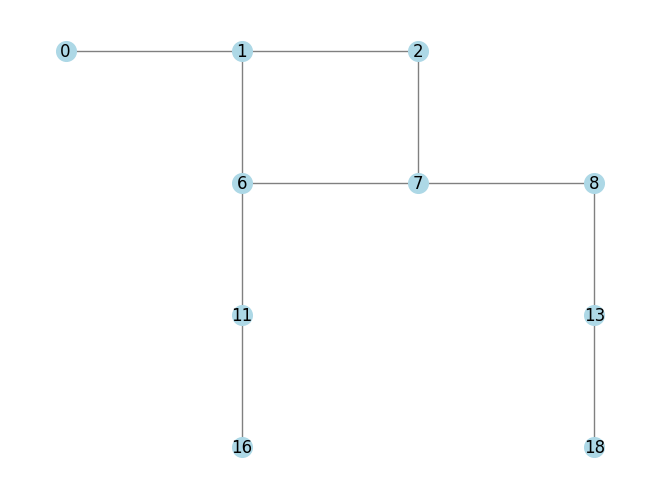

([0, 1, 6, 7, 8, 13, 18], 6)

In [433]:
grid = np.array(
    [
        [1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0],
    ]
)

waypoints = {
    "A": (0, 0),
    "B": (3, 3),
}

g = Grid(grid, waypoints)
path = g.find_path("A", "B")
# g.plot(path)
g.plot_graph()
path

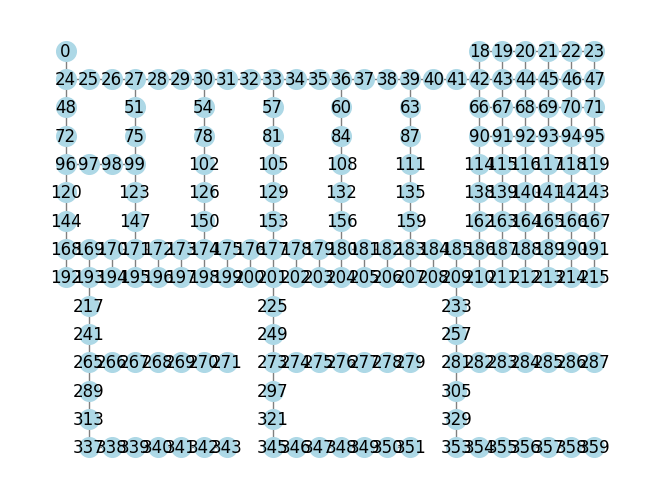

([0, 24, 25, 26, 27, 28, 29, 30, 54, 78, 102, 126, 150, 174, 198, 199, 200, 201, 225, 249, 273, 274, 275, 276, 277, 278, 279], 26)


In [434]:
grid = np.loadtxt("static/fruteria.csv", delimiter=",", dtype=int)
%matplotlib inline
waypoints = {
    "A": (0, 0),
    "B": (15, 11),
    "C": (7, 11),
}

g = Grid(grid, waypoints)
path = g.find_path("A", "B")
# g.plot(path)
g.plot_graph()
print(path)

# Create Bin Locations

In [435]:
df_wh = pd.DataFrame()
rows = []
for n, pos in enumerate(np.ndindex(grid.shape)):
    if grid[pos] == 0:
        rows.append({"x": pos[1], "y": pos[0], "node": g.pos2node(pos[::-1]), "path": False})
    elif grid[pos] == 1:
        rows.append({"x": pos[1], "y": pos[0],"node": g.pos2node(pos[::-1]), "path": True})
df_wh = pd.concat([df_wh, pd.DataFrame(rows)], ignore_index=True)

# Remove some bins
df_wh = df_wh[~((df_wh["x"] == 0) & (df_wh["y"] == 0))]

def remove_bins(width, height, x_size, node):
    result_list = []
    for i in range(height):
        i = i * x_size
        x = list(range(node + i, node+width + i))
        result_list.extend(x)
    return result_list

df_wh = df_wh[df_wh["path"] == True]
# Remove nodes 168 to 215
df_wh = df_wh[~df_wh["node"].between(168, 215)]
# Remove nodes if they are in a specific list
df_wh = df_wh[~df_wh["node"].isin(remove_bins(3, 3, 24, 0))]
df_wh = df_wh[~df_wh["node"].isin(remove_bins(1, 7, 24, 193))]
df_wh = df_wh[~df_wh["node"].isin(remove_bins(1, 7, 24, 201))]
df_wh = df_wh[~df_wh["node"].isin(remove_bins(1, 7, 24, 209))]

df_wh.head()

,x,y,node,path
18,18,0,18,True
19,19,0,19,True
20,20,0,20,True
21,21,0,21,True
22,22,0,22,True


In [436]:
df_wh.to_csv("static/warehouse.csv", index=False)

In [437]:
possible_bins = df_wh["node"].to_list()

In [438]:
df2 = pd.read_csv("static/fruits.csv")
df2["bin"] = np.random.choice(possible_bins, df2.shape[0])
df2.head()

,Name,Category,bin
0,Abiu,Fruit,71
1,Açaí,Fruit,40
2,Acerola,Fruit,45
3,Akebi,Fruit,163
4,Ackee,Fruit,22


In [439]:
# Generate work orders
wos = 200

# Check if wos file is already generated
if os.path.isfile(f"static/fruit_wos_{wos}.parquet"):
    df_wo2 = pd.read_parquet(f"static/fruit_wos_{wos}.parquet")
    print(f"Loaded {df_wo2.shape[0]} work orders")
else:
    print(f"Generating {wos} work orders")
    df_wo2 = pd.DataFrame(columns=df2.columns)
    for _ in range(wos):
        random_row = df2.sample()
        df_wo2 = pd.concat([df_wo2, random_row], ignore_index=True)
    df_wo2.to_parquet(f"static/fruit_wos_{wos}.parquet")
df_wo2.head()

Loaded 200 work orders


,Name,Category,bin
0,Orange,Fruit,271
1,Thimbleberry,Fruit,147
2,Sloe,Fruit,267
3,Pawpaw,Fruit,20
4,Suriname cherry,Fruit,166


In [440]:
# add location info to bins
df_wo2 = df_wo2.merge(df_wh, left_on="bin", right_on="node", how="left").drop(columns=["node", "path"])
df_wo2.head()

,Name,Category,bin,x,y
0,Orange,Fruit,271,7,11
1,Thimbleberry,Fruit,147,3,6
2,Sloe,Fruit,267,3,11
3,Pawpaw,Fruit,20,20,0
4,Suriname cherry,Fruit,166,22,6


In [441]:
# Split work orders into batches of 10
batch_size2 = 10
fetch_list2 = []
for i in range(int(np.floor(df_wo2.count().Category) / batch_size2)):
    fetch_list2.append(df_wo2.loc[i * 10 : i * 10 + 10])
fetch_list2[0]

,Name,Category,bin,x,y
0,Orange,Fruit,271,7,11
1,Thimbleberry,Fruit,147,3,6
2,Sloe,Fruit,267,3,11
3,Pawpaw,Fruit,20,20,0
4,Suriname cherry,Fruit,166,22,6
5,White sapote,Fruit,275,11,11
6,Honeyberry,Fruit,37,13,1
7,Gooseberry,Fruit,45,21,1
8,Abiu,Fruit,38,14,1
9,Mouse melon,Fruit,32,8,1


In [442]:
# Solve the TSP for a random batch pick order
results = []
for fetch in fetch_list2:
    pickup_list = fetch.bin.values.tolist()
    tsp_route, tsp_distance, pickup_order = g.tsp([0], pickup_list)
    results.append({
        "pickup_list": pickup_list,
        "tsp_route": tsp_route,
        "tsp_distance": tsp_distance,
        "pickup_order": pickup_order
    })

df_results = pd.DataFrame(results)
print(f"Total distance for a random pick order: {df_results.tsp_distance.sum()}")
df_results.head()

Total distance for a random pick order: 2268


,pickup_list,tsp_route,tsp_distance,pickup_order
0,"[271, 147, 267, 20, 166, 275, 37, 45, 38, 32, ...","[0, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34...",114,"[32, 37, 38, 20, 45, 166, 357, 275, 147, 267, ..."
1,"[357, 21, 351, 70, 30, 143, 46, 91, 66, 140, 129]","[0, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34...",116,"[30, 66, 91, 140, 21, 46, 70, 143, 357, 351, 129]"
2,"[129, 96, 72, 45, 37, 287, 117, 150, 359, 348,...","[0, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 57...",128,"[129, 348, 156, 287, 359, 117, 45, 37, 150, 96..."
3,"[156, 275, 90, 119, 27, 71, 57, 18, 138, 142, 45]","[0, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 57...",86,"[27, 57, 275, 156, 138, 142, 119, 71, 45, 18, 90]"
4,"[45, 150, 354, 166, 147, 46, 92, 282, 278, 342...","[0, 24, 48, 72, 96, 120, 144, 168, 169, 193, 2...",134,"[342, 147, 150, 282, 354, 166, 46, 45, 92, 278]"


# Split orders into groups of 10 or less and optimize for shortest total distance using clustering algorithms

<Axes: title={'center': 'Bins Distribution'}, xlabel='bin'>

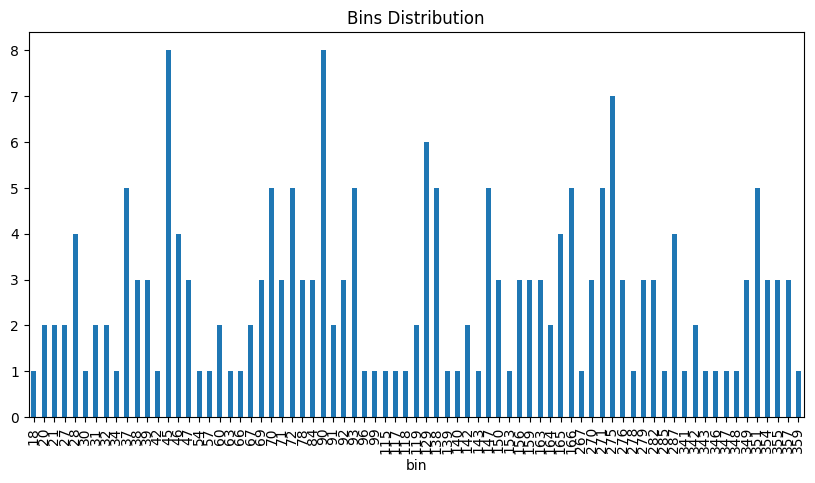

In [443]:
df_wo2.bin.value_counts().sort_index().plot(kind="bar", figsize=(10, 5), title="Bins Distribution")

In [444]:
sorted_bins = np.sort(df_wo2.bin.unique())

In [445]:
# Construct distance matrix
nodes = np.sort(df_wo2.bin.unique())
n = len(nodes)
distance_matrix = np.zeros((n, n))

for i, i_n in enumerate(nodes):
    for j, j_n in enumerate(nodes):
        if i != j:
            # Compute the shortest path distance between nodes[i] and nodes[j]
            distance_matrix[i, j] = g.find_path(i_n, j_n, node=True)[1]
distance_matrix

array([[ 0.,  2.,  3., ..., 17., 19., 21.],
       [ 2.,  0.,  1., ..., 19., 21., 23.],
       [ 3.,  1.,  0., ..., 20., 22., 24.],
       ...,
       [17., 19., 20., ...,  0.,  2.,  4.],
       [19., 21., 22., ...,  2.,  0.,  2.],
       [21., 23., 24., ...,  4.,  2.,  0.]])

In [452]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
condensed_distance = squareform(distance_matrix)
Z = linkage(condensed_distance, method="average")
k = int(len(df_wo2) / batch_size2)
clusters = fcluster(Z, k, criterion="maxclust")
clusters

array([ 7,  8,  8, 16, 16, 17, 17, 17, 15,  9,  9,  9,  7,  8,  8,  8, 17,
       15, 10,  9,  7,  7,  8,  8,  8, 12, 17, 10,  7,  7,  6,  6, 12, 13,
        6,  6,  6,  6, 14,  6,  6,  6,  6,  6, 13, 18, 14, 10, 11,  6,  6,
        6,  6,  2,  2,  2, 19, 19, 19, 19,  5,  4,  4,  1,  1,  1, 20, 20,
       20, 20, 20,  3,  3,  3,  3], dtype=int32)

In [447]:
for node, cluster in zip(nodes, clusters):
    df_wo2.loc[df_wo2["bin"] == node, "cluster"] = cluster
df_wo2.groupby("cluster").size()

cluster
1.0      4
2.0      9
3.0     10
4.0      5
5.0      3
6.0     37
7.0     15
8.0     30
9.0     12
10.0     8
11.0     3
12.0     6
13.0     6
14.0     7
15.0     2
16.0     6
17.0     9
18.0     3
19.0    14
20.0    11
dtype: int64

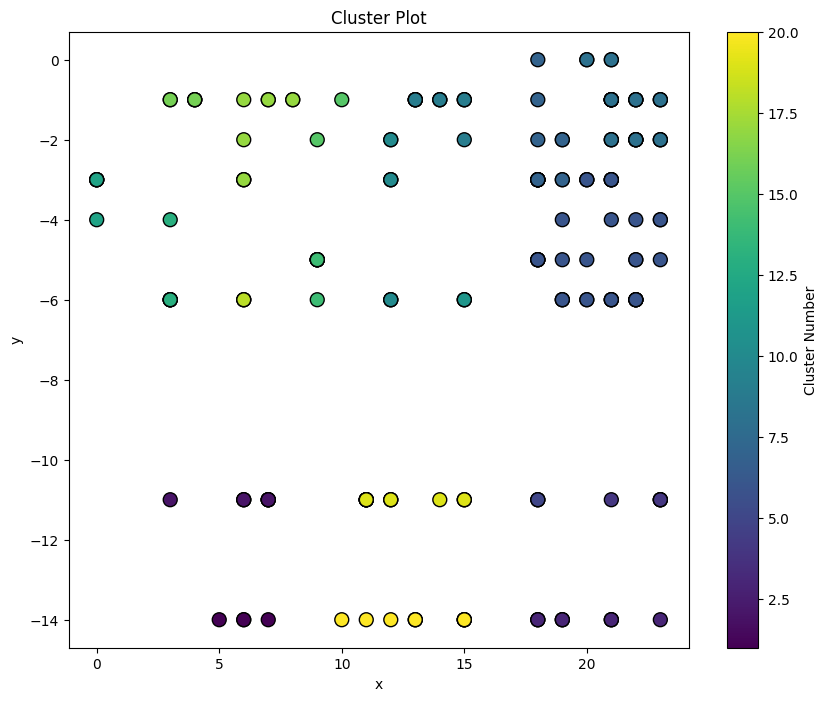

In [448]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_wo2['x'], -df_wo2['y'], 
                      c=df_wo2['cluster'],       # Color points by cluster number.
                      cmap='viridis',        # Choose a colormap.
                      s=100,                 # Size of each point.
                      edgecolor='k')         # Optional: add a black edge for better contrast.

# Add a colorbar to show cluster numbers.
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Number')

# Add plot labels and title.
plt.xlabel('x')
plt.ylabel('y')
plt.title('Cluster Plot')

plt.show()

In [449]:
# resolve TSP
# Group by clusters and convert to lists of nodes
fetch_list3 = []
for cluster in df_wo2["cluster"].unique():
    nodes = df_wo2[df_wo2["cluster"] == cluster].bin.values.tolist()
    fetch_list3.append(nodes)


In [450]:
results3 = []
for pickup_list in fetch_list3:
    pickup = np.unique(pickup_list).tolist()
    tsp_route, tsp_distance, pickup_order = g.tsp([0], pickup_list)
    results3.append({
        "pickup_list": pickup_list,
        "tsp_route": tsp_route,
        "tsp_distance": tsp_distance,
        "pickup_order": pickup_order
    })

df_results = pd.DataFrame(results3)
print(f"Total distance for clustered pickup list: {df_results.tsp_distance.sum()}")
df_results.head()

Total distance for clustered pickup list: 798


,pickup_list,tsp_route,tsp_distance,pickup_order
0,"[271, 267, 271, 271, 270, 271, 270, 271, 270]","[0, 24, 48, 72, 96, 120, 144, 168, 169, 193, 2...",36,"[267, 270, 271]"
1,"[147, 147, 147, 147, 99, 147]","[0, 24, 25, 26, 27, 51, 75, 99, 123, 147, 123,...",18,"[99, 147]"
2,"[20, 45, 21, 70, 46, 45, 71, 45, 46, 46, 46, 7...","[0, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34...",54,"[45, 69, 46, 47, 71, 70, 21, 20]"
3,"[166, 143, 140, 117, 119, 138, 142, 166, 92, 1...","[0, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34...",62,"[92, 93, 117, 118, 119, 143, 142, 166, 165, 16..."
4,"[275, 275, 278, 276, 279, 275, 279, 275, 276, ...","[0, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 57...",52,"[275, 276, 278, 279]"
